In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, random_split


In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')

In [3]:
data = pd.merge(ratings, movies, on='MovieID')
data = pd.merge(data, users, on='UserID')
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [4]:
movie_id_to_name = pd.Series(movies.Title.values, index=movies.MovieID).to_dict()


In [5]:
user_counts = data['UserID'].value_counts()
filtered_users = user_counts[user_counts >= 5].index
data = data[data['UserID'].isin(filtered_users)]
print(f"Data after filtering: {data.shape}")

Data after filtering: (1000209, 10)


In [6]:
movie_counts = data['MovieID'].value_counts()
filtered_movies = movie_counts[movie_counts >= 5].index
data = data[data['MovieID'].isin(filtered_movies)]
print(f"Data after filtering: {data.shape}")

Data after filtering: (999611, 10)


In [7]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
print(data[['UserID','MovieID','Timestamp']].head())

   UserID  MovieID           Timestamp
0       1     1193 2000-12-31 22:12:40
1       1      661 2000-12-31 22:35:09
2       1      914 2000-12-31 22:32:48
3       1     3408 2000-12-31 22:04:35
4       1     2355 2001-01-06 23:38:11


In [8]:
user_encoder = LabelEncoder()
data["EncodedUserID"] = user_encoder.fit_transform(data["UserID"]) + 1
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,EncodedUserID
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,1
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,1
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,48067,1
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,48067,1
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,1


In [9]:
movie_encoder = LabelEncoder()
data["EncodedMovieID"] = movie_encoder.fit_transform(data["MovieID"]) + 1
print (data["EncodedMovieID"].head())

0     995
1     596
2     763
3    2926
4    1993
Name: EncodedMovieID, dtype: int64


In [10]:
print(data['EncodedMovieID'].nunique())  
print(data['EncodedMovieID'].max())  


3416
3416


In [11]:
movie_id_to_name = pd.Series(movies.Title.values, index=movies.MovieID).to_dict()
encoded_movie_id_to_name = {
    movie_encoder.transform([k])[0] + 1: v for k, v in movie_id_to_name.items() if k in movie_encoder.classes_
}
encoded_movie_name_to_id = {v: k for k, v in encoded_movie_id_to_name.items()}

In [12]:
data = data.sort_values(["EncodedUserID", "Timestamp"]).reset_index(drop=True)
print(data[['EncodedMovieID','Timestamp']].head())

   EncodedMovieID           Timestamp
0            2758 2000-12-31 22:00:19
1            1069 2000-12-31 22:00:55
2            1445 2000-12-31 22:00:55
3             862 2000-12-31 22:00:55
4            1979 2000-12-31 22:01:43


In [13]:
def generate_sequences(sequence, window_size=10):
    if len(sequence) < window_size:
        sequence = [0] * (window_size - len(sequence)) + sequence        
    return [sequence[i:i + window_size] for i in range(len(sequence) - window_size + 1)]


In [14]:
if (data['EncodedMovieID'] == 0).any():
    print("The encoder assigned 0 as a value for some EncodedMovieID entries.")
else:
    print("No EncodedMovieID entry has been assigned the value 0.")

if (data['EncodedUserID'] == 0).any():
    print("The encoder assigned 0 as a value for some EncodedUserID entries.")
else:
    print("No EncodedUserID entry has been assigned the value 0.")



No EncodedMovieID entry has been assigned the value 0.
No EncodedUserID entry has been assigned the value 0.


In [15]:
user_sequences = data.groupby('EncodedUserID')['EncodedMovieID'].apply(list).values
print(user_sequences[:2])
print(len(user_sequences))

[list([2758, 1069, 1445, 862, 1979, 1520, 2926, 2412, 1008, 995, 634, 242, 768, 562, 2303, 1631, 1698, 2686, 787, 875, 1632, 1688, 135, 868, 927, 763, 1086, 2405, 2370, 1045, 596, 2514, 497, 2695, 2399, 1960, 869, 998, 551, 2035, 1302, 494, 552, 2298, 649, 546, 1, 1993, 1937, 674, 1315, 1579, 47])
 list([999, 1011, 1018, 2326, 1092, 2539, 1026, 995, 296, 2617, 2459, 1014, 1615, 1008, 550, 2676, 2981, 1548, 482, 920, 2134, 2622, 105, 1735, 2723, 1046, 2686, 1148, 997, 1627, 1623, 769, 1518, 914, 1632, 2984, 3140, 3218, 1058, 1624, 1486, 2337, 1638, 932, 751, 2967, 3078, 2453, 2868, 2652, 247, 1952, 548, 1052, 2655, 1043, 3183, 1625, 1044, 1885, 3163, 827, 1860, 1914, 1221, 2807, 588, 217, 926, 945, 465, 1045, 3360, 1295, 990, 2033, 1996, 1960, 333, 2689, 1064, 3286, 547, 1698, 2197, 424, 2512, 1353, 447, 148, 357, 2934, 2808, 1192, 21, 326, 1288, 1991, 1676, 1921, 1158, 589, 2064, 1490, 1160, 1308, 2123, 1173, 671, 2481, 2688, 345, 1497, 150, 426, 409, 1341, 2242, 1426, 2809, 644, 1672,

In [16]:
user_interaction_counts = [len(seq) for seq in user_sequences]
filtered_user_sequences = [
    seq for seq, count in zip(user_sequences, user_interaction_counts)
    if 10 <= count <= 100  
]
all_sequences = []
for seq in filtered_user_sequences:
    all_sequences.extend(generate_sequences(seq))
print(len(all_sequences))

128306


In [17]:
print(all_sequences[:5])

[[2758, 1069, 1445, 862, 1979, 1520, 2926, 2412, 1008, 995], [1069, 1445, 862, 1979, 1520, 2926, 2412, 1008, 995, 634], [1445, 862, 1979, 1520, 2926, 2412, 1008, 995, 634, 242], [862, 1979, 1520, 2926, 2412, 1008, 995, 634, 242, 768], [1979, 1520, 2926, 2412, 1008, 995, 634, 242, 768, 562]]


In [18]:
all_sequences = torch.tensor(all_sequences, dtype=torch.long)
inputs = all_sequences[:, :-1]  
targets = all_sequences[:, -1]  
print(inputs[:5])

tensor([[2758, 1069, 1445,  862, 1979, 1520, 2926, 2412, 1008],
        [1069, 1445,  862, 1979, 1520, 2926, 2412, 1008,  995],
        [1445,  862, 1979, 1520, 2926, 2412, 1008,  995,  634],
        [ 862, 1979, 1520, 2926, 2412, 1008,  995,  634,  242],
        [1979, 1520, 2926, 2412, 1008,  995,  634,  242,  768]])


In [19]:
print(targets)


tensor([ 995,  634,  242,  ..., 1202, 2310,  985])


In [20]:
print(f'Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')


Inputs shape: torch.Size([128306, 9]), Targets shape: torch.Size([128306])


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split


dataset = TensorDataset(inputs, targets)

total_size = len(dataset)
train_size = int(0.7 * total_size)  
val_size = int(0.15 * total_size)   
test_size = total_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 89814
Validation size: 19245
Test size: 19247


In [22]:
for batch_inputs, batch_targets in train_loader:
    print(f'Batch Inputs: {batch_inputs.shape}, Batch Targets: {batch_targets.shape}')
    break

Batch Inputs: torch.Size([256, 9]), Batch Targets: torch.Size([256])


In [26]:
import pickle
with open("movie_mappings.pkl", "wb") as f:
    pickle.dump(
        {
            "encoded_movie_id_to_name": encoded_movie_id_to_name,
            "encoded_movie_name_to_id": encoded_movie_name_to_id,
        },
        f,
    )

In [27]:
num_items = data['EncodedMovieID'].nunique() + 1
print(num_items)

3417


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        assert embedding_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)

        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, E = x.size()  

        Q = self.query(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        output = torch.matmul(attn, V)
        output = output.transpose(1, 2).contiguous().view(B, N, E)

        return self.out(output)

class PointWiseFeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout=0.1):
        super(PointWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        return self.linear2(x)

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.msa = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.ffn = PointWiseFeedForward(embedding_dim, ff_dim, dropout)

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.msa(self.norm1(x)))
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x

class ModelAugmentation(nn.Module):
    def __init__(self, embedding_dim, dropout=0.1):
        super(ModelAugmentation, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, embedding_dim)
        )
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(self.ffn(x) + x)

class UET4Rec(nn.Module):
    def __init__(self, num_items, embedding_dim=128, nhead=8, max_len=9, dropout=0.7, ff_dim=256):
        super(UET4Rec, self).__init__()

        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)

        self.position_embedding = nn.Embedding(max_len, embedding_dim)

        self.encoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 8, kernel_size=5, padding=2)
        )

        self.transformer = nn.ModuleList([
            CustomTransformerEncoderLayer(embedding_dim // 8, nhead, ff_dim, dropout) for _ in range(3)
        ])

        self.decoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim // 8, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim, kernel_size=5, padding=2)
        )

        self.ma = ModelAugmentation(embedding_dim, dropout)

        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, x):
        batch_size, seq_len = x.size()

        positions = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x = self.item_embedding(x) + self.position_embedding(positions)

        x = x.permute(0, 2, 1)  
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        x = enc3.permute(0, 2, 1)  
        for layer in self.transformer:
            x = layer(x)
        x = x.permute(0, 2, 1)  

        dec1 = self.decoder1(x + enc3)  
        dec2 = self.decoder2(dec1 + enc2)  
        dec3 = self.decoder3(dec2 + enc1)  

        x = dec3[:, :, -1]  
        x = self.ma(x)  
        out = self.fc(x)  

        return out
embedding_dim = 128
nhead = 8
ff_dim = 256
dropout = 0.7
max_len = 9

model = UET4Rec(
    num_items=num_items,
    embedding_dim=embedding_dim,
    nhead=nhead,
    max_len=max_len,
    dropout=dropout,
    ff_dim=ff_dim
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

UET4Rec(
  (item_embedding): Embedding(3417, 128, padding_idx=0)
  (position_embedding): Embedding(9, 128)
  (encoder1): Sequential(
    (0): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.7, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.7, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (transformer): ModuleList(
    (0-2): 3 x CustomTransformerEncoderLayer(
      (msa): MultiHeadSelfAttention(
        (query): Linear(in_features=16, out_features=16, bias=True)
        (key): Linear(in_features=16, out_features=16, bias=True)
        (value)

In [29]:
import torch
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 250
save_interval = 20  
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as progress_bar:
        for batch_inputs, batch_targets in progress_bar:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()

            outputs = model(batch_inputs)

            loss = criterion(outputs, batch_targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")

    if (epoch + 1) % save_interval == 0:
        model_save_path = f"uet4rec_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved after {epoch+1} epochs at '{model_save_path}'.")

final_model_path = "uet4rec_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as '{final_model_path}'.")

print("Training Completed.")


Using device: cuda
Starting Training...


Epoch [1/250]: 100%|█████████████████████████████████████████████| 351/351 [00:26<00:00, 13.43batch/s, Batch Loss=7.22]


Epoch [1/250], Training Loss: 7.2483


Epoch [2/250]: 100%|█████████████████████████████████████████████| 351/351 [00:16<00:00, 20.88batch/s, Batch Loss=7.11]


Epoch [2/250], Training Loss: 7.1363


Epoch [3/250]: 100%|█████████████████████████████████████████████| 351/351 [00:16<00:00, 21.08batch/s, Batch Loss=6.64]


Epoch [3/250], Training Loss: 6.8644


Epoch [4/250]: 100%|█████████████████████████████████████████████| 351/351 [00:17<00:00, 20.62batch/s, Batch Loss=6.35]


Epoch [4/250], Training Loss: 6.3768


Epoch [5/250]: 100%|█████████████████████████████████████████████| 351/351 [00:16<00:00, 21.07batch/s, Batch Loss=6.02]


Epoch [5/250], Training Loss: 6.1081


Epoch [6/250]: 100%|██████████████████████████████████████████████| 351/351 [00:14<00:00, 23.75batch/s, Batch Loss=6.1]


Epoch [6/250], Training Loss: 5.9441


Epoch [7/250]: 100%|█████████████████████████████████████████████| 351/351 [00:14<00:00, 23.43batch/s, Batch Loss=5.74]


Epoch [7/250], Training Loss: 5.8318


Epoch [8/250]: 100%|█████████████████████████████████████████████| 351/351 [00:15<00:00, 23.00batch/s, Batch Loss=5.72]


Epoch [8/250], Training Loss: 5.7431


Epoch [9/250]: 100%|█████████████████████████████████████████████| 351/351 [00:14<00:00, 24.37batch/s, Batch Loss=5.66]


Epoch [9/250], Training Loss: 5.6695


Epoch [10/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.93batch/s, Batch Loss=5.57]


Epoch [10/250], Training Loss: 5.6091


Epoch [11/250]: 100%|█████████████████████████████████████████████| 351/351 [00:15<00:00, 22.86batch/s, Batch Loss=5.5]


Epoch [11/250], Training Loss: 5.5536


Epoch [12/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.45batch/s, Batch Loss=5.56]


Epoch [12/250], Training Loss: 5.5115


Epoch [13/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.46batch/s, Batch Loss=5.59]


Epoch [13/250], Training Loss: 5.4672


Epoch [14/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.24batch/s, Batch Loss=5.41]


Epoch [14/250], Training Loss: 5.4291


Epoch [15/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.04batch/s, Batch Loss=5.49]


Epoch [15/250], Training Loss: 5.3936


Epoch [16/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.85batch/s, Batch Loss=5.38]


Epoch [16/250], Training Loss: 5.3587


Epoch [17/250]: 100%|████████████████████████████████████████████| 351/351 [00:16<00:00, 21.81batch/s, Batch Loss=5.29]


Epoch [17/250], Training Loss: 5.3311


Epoch [18/250]: 100%|████████████████████████████████████████████| 351/351 [00:16<00:00, 21.59batch/s, Batch Loss=5.29]


Epoch [18/250], Training Loss: 5.3074


Epoch [19/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.26batch/s, Batch Loss=5.15]


Epoch [19/250], Training Loss: 5.2868


Epoch [20/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.18batch/s, Batch Loss=5.58]


Epoch [20/250], Training Loss: 5.2619
Model saved after 20 epochs at 'uet4rec_model_epoch_20.pth'.


Epoch [21/250]: 100%|█████████████████████████████████████████████| 351/351 [00:14<00:00, 24.60batch/s, Batch Loss=5.1]


Epoch [21/250], Training Loss: 5.2336


Epoch [22/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.96batch/s, Batch Loss=5.31]


Epoch [22/250], Training Loss: 5.2202


Epoch [23/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.70batch/s, Batch Loss=5.02]


Epoch [23/250], Training Loss: 5.1934


Epoch [24/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 23.72batch/s, Batch Loss=5.21]


Epoch [24/250], Training Loss: 5.1732


Epoch [25/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.79batch/s, Batch Loss=5.39]


Epoch [25/250], Training Loss: 5.1524


Epoch [26/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.10batch/s, Batch Loss=5.11]


Epoch [26/250], Training Loss: 5.1395


Epoch [27/250]: 100%|█████████████████████████████████████████████| 351/351 [00:14<00:00, 24.62batch/s, Batch Loss=5.2]


Epoch [27/250], Training Loss: 5.1185


Epoch [28/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.83batch/s, Batch Loss=5.27]


Epoch [28/250], Training Loss: 5.1062


Epoch [29/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.41batch/s, Batch Loss=5.28]


Epoch [29/250], Training Loss: 5.0886


Epoch [30/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.98batch/s, Batch Loss=4.96]


Epoch [30/250], Training Loss: 5.0751


Epoch [31/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.10batch/s, Batch Loss=5.18]


Epoch [31/250], Training Loss: 5.0588


Epoch [32/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.91batch/s, Batch Loss=5.19]


Epoch [32/250], Training Loss: 5.0426


Epoch [33/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 23.36batch/s, Batch Loss=4.88]


Epoch [33/250], Training Loss: 5.0245


Epoch [34/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.35batch/s, Batch Loss=5.23]


Epoch [34/250], Training Loss: 5.0147


Epoch [35/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 23.52batch/s, Batch Loss=5.01]


Epoch [35/250], Training Loss: 5.0024


Epoch [36/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.47batch/s, Batch Loss=5.16]


Epoch [36/250], Training Loss: 4.9868


Epoch [37/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.25batch/s, Batch Loss=5.06]


Epoch [37/250], Training Loss: 4.9722


Epoch [38/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.48batch/s, Batch Loss=4.81]


Epoch [38/250], Training Loss: 4.9600


Epoch [39/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.59batch/s, Batch Loss=4.72]


Epoch [39/250], Training Loss: 4.9507


Epoch [40/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.38batch/s, Batch Loss=5.12]


Epoch [40/250], Training Loss: 4.9418
Model saved after 40 epochs at 'uet4rec_model_epoch_40.pth'.


Epoch [41/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.89batch/s, Batch Loss=4.89]


Epoch [41/250], Training Loss: 4.9229


Epoch [42/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.25batch/s, Batch Loss=5.13]


Epoch [42/250], Training Loss: 4.9155


Epoch [43/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.60batch/s, Batch Loss=5.06]


Epoch [43/250], Training Loss: 4.8969


Epoch [44/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.46batch/s, Batch Loss=4.89]


Epoch [44/250], Training Loss: 4.8872


Epoch [45/250]: 100%|███████████████████████████████████████████████| 351/351 [00:14<00:00, 24.24batch/s, Batch Loss=5]


Epoch [45/250], Training Loss: 4.8823


Epoch [46/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.22batch/s, Batch Loss=4.95]


Epoch [46/250], Training Loss: 4.8673


Epoch [47/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 25.07batch/s, Batch Loss=5.03]


Epoch [47/250], Training Loss: 4.8574


Epoch [48/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.72batch/s, Batch Loss=5.14]


Epoch [48/250], Training Loss: 4.8461


Epoch [49/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.89batch/s, Batch Loss=4.94]


Epoch [49/250], Training Loss: 4.8374


Epoch [50/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.48batch/s, Batch Loss=4.94]


Epoch [50/250], Training Loss: 4.8307


Epoch [51/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.85batch/s, Batch Loss=5.01]


Epoch [51/250], Training Loss: 4.8216


Epoch [52/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.87batch/s, Batch Loss=4.88]


Epoch [52/250], Training Loss: 4.8001


Epoch [53/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.80batch/s, Batch Loss=4.74]


Epoch [53/250], Training Loss: 4.8006


Epoch [54/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 25.06batch/s, Batch Loss=4.96]


Epoch [54/250], Training Loss: 4.7873


Epoch [55/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.85batch/s, Batch Loss=4.83]


Epoch [55/250], Training Loss: 4.7820


Epoch [56/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.37batch/s, Batch Loss=4.59]


Epoch [56/250], Training Loss: 4.7657


Epoch [57/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.96batch/s, Batch Loss=4.76]


Epoch [57/250], Training Loss: 4.7646


Epoch [58/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.41batch/s, Batch Loss=4.85]


Epoch [58/250], Training Loss: 4.7505


Epoch [59/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.47batch/s, Batch Loss=4.62]


Epoch [59/250], Training Loss: 4.7434


Epoch [60/250]: 100%|█████████████████████████████████████████████| 351/351 [00:16<00:00, 21.27batch/s, Batch Loss=4.8]


Epoch [60/250], Training Loss: 4.7324
Model saved after 60 epochs at 'uet4rec_model_epoch_60.pth'.


Epoch [61/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.02batch/s, Batch Loss=5.04]


Epoch [61/250], Training Loss: 4.7220


Epoch [62/250]: 100%|████████████████████████████████████████████| 351/351 [00:17<00:00, 19.54batch/s, Batch Loss=4.97]


Epoch [62/250], Training Loss: 4.7187


Epoch [63/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 23.36batch/s, Batch Loss=4.85]


Epoch [63/250], Training Loss: 4.7125


Epoch [64/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.72batch/s, Batch Loss=4.47]


Epoch [64/250], Training Loss: 4.7007


Epoch [65/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.10batch/s, Batch Loss=4.78]


Epoch [65/250], Training Loss: 4.6870


Epoch [66/250]: 100%|████████████████████████████████████████████| 351/351 [00:16<00:00, 21.27batch/s, Batch Loss=4.76]


Epoch [66/250], Training Loss: 4.6852


Epoch [67/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.01batch/s, Batch Loss=4.69]


Epoch [67/250], Training Loss: 4.6852


Epoch [68/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 23.04batch/s, Batch Loss=4.87]


Epoch [68/250], Training Loss: 4.6726


Epoch [69/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.59batch/s, Batch Loss=4.57]


Epoch [69/250], Training Loss: 4.6670


Epoch [70/250]: 100%|████████████████████████████████████████████| 351/351 [00:17<00:00, 20.45batch/s, Batch Loss=4.81]


Epoch [70/250], Training Loss: 4.6592


Epoch [71/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.40batch/s, Batch Loss=4.66]


Epoch [71/250], Training Loss: 4.6483


Epoch [72/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.70batch/s, Batch Loss=4.64]


Epoch [72/250], Training Loss: 4.6469


Epoch [73/250]: 100%|████████████████████████████████████████████| 351/351 [00:16<00:00, 20.67batch/s, Batch Loss=4.66]


Epoch [73/250], Training Loss: 4.6323


Epoch [74/250]: 100%|█████████████████████████████████████████████| 351/351 [00:17<00:00, 19.87batch/s, Batch Loss=4.6]


Epoch [74/250], Training Loss: 4.6252


Epoch [75/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.48batch/s, Batch Loss=4.63]


Epoch [75/250], Training Loss: 4.6255


Epoch [76/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.68batch/s, Batch Loss=4.87]


Epoch [76/250], Training Loss: 4.6106


Epoch [77/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.18batch/s, Batch Loss=4.65]


Epoch [77/250], Training Loss: 4.6060


Epoch [78/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.34batch/s, Batch Loss=4.68]


Epoch [78/250], Training Loss: 4.6022


Epoch [79/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.26batch/s, Batch Loss=4.64]


Epoch [79/250], Training Loss: 4.5891


Epoch [80/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.67batch/s, Batch Loss=4.55]


Epoch [80/250], Training Loss: 4.5871
Model saved after 80 epochs at 'uet4rec_model_epoch_80.pth'.


Epoch [81/250]: 100%|█████████████████████████████████████████████| 351/351 [00:13<00:00, 25.93batch/s, Batch Loss=4.6]


Epoch [81/250], Training Loss: 4.5774


Epoch [82/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 28.62batch/s, Batch Loss=4.76]


Epoch [82/250], Training Loss: 4.5784


Epoch [83/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.44batch/s, Batch Loss=4.48]


Epoch [83/250], Training Loss: 4.5696


Epoch [84/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 29.66batch/s, Batch Loss=4.67]


Epoch [84/250], Training Loss: 4.5635


Epoch [85/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 28.69batch/s, Batch Loss=4.73]


Epoch [85/250], Training Loss: 4.5611


Epoch [86/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.47batch/s, Batch Loss=4.55]


Epoch [86/250], Training Loss: 4.5482


Epoch [87/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.67batch/s, Batch Loss=4.75]


Epoch [87/250], Training Loss: 4.5428


Epoch [88/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 28.69batch/s, Batch Loss=4.63]


Epoch [88/250], Training Loss: 4.5389


Epoch [89/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 28.66batch/s, Batch Loss=4.43]


Epoch [89/250], Training Loss: 4.5361


Epoch [90/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.34batch/s, Batch Loss=4.42]


Epoch [90/250], Training Loss: 4.5250


Epoch [91/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.73batch/s, Batch Loss=4.76]


Epoch [91/250], Training Loss: 4.5191


Epoch [92/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.32batch/s, Batch Loss=4.61]


Epoch [92/250], Training Loss: 4.5162


Epoch [93/250]: 100%|█████████████████████████████████████████████| 351/351 [00:12<00:00, 27.60batch/s, Batch Loss=4.8]


Epoch [93/250], Training Loss: 4.5051


Epoch [94/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 28.85batch/s, Batch Loss=4.56]


Epoch [94/250], Training Loss: 4.5034


Epoch [95/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.16batch/s, Batch Loss=4.73]


Epoch [95/250], Training Loss: 4.4895


Epoch [96/250]: 100%|████████████████████████████████████████████| 351/351 [00:12<00:00, 27.02batch/s, Batch Loss=4.63]


Epoch [96/250], Training Loss: 4.4860


Epoch [97/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 23.29batch/s, Batch Loss=4.36]


Epoch [97/250], Training Loss: 4.4936


Epoch [98/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.75batch/s, Batch Loss=4.76]


Epoch [98/250], Training Loss: 4.4846


Epoch [99/250]: 100%|████████████████████████████████████████████| 351/351 [00:15<00:00, 22.81batch/s, Batch Loss=4.45]


Epoch [99/250], Training Loss: 4.4688


Epoch [100/250]: 100%|███████████████████████████████████████████| 351/351 [00:15<00:00, 22.39batch/s, Batch Loss=4.59]


Epoch [100/250], Training Loss: 4.4748
Model saved after 100 epochs at 'uet4rec_model_epoch_100.pth'.


Epoch [101/250]: 100%|███████████████████████████████████████████| 351/351 [00:14<00:00, 23.51batch/s, Batch Loss=4.52]


Epoch [101/250], Training Loss: 4.4637


Epoch [102/250]: 100%|███████████████████████████████████████████| 351/351 [00:14<00:00, 23.44batch/s, Batch Loss=4.29]


Epoch [102/250], Training Loss: 4.4565


Epoch [103/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 26.41batch/s, Batch Loss=4.7]


Epoch [103/250], Training Loss: 4.4561


Epoch [104/250]: 100%|███████████████████████████████████████████| 351/351 [00:16<00:00, 21.62batch/s, Batch Loss=4.41]


Epoch [104/250], Training Loss: 4.4534


Epoch [105/250]: 100%|███████████████████████████████████████████| 351/351 [00:16<00:00, 21.17batch/s, Batch Loss=4.59]


Epoch [105/250], Training Loss: 4.4432


Epoch [106/250]: 100%|███████████████████████████████████████████| 351/351 [00:18<00:00, 19.25batch/s, Batch Loss=4.24]


Epoch [106/250], Training Loss: 4.4380


Epoch [107/250]: 100%|███████████████████████████████████████████| 351/351 [00:18<00:00, 18.95batch/s, Batch Loss=4.41]


Epoch [107/250], Training Loss: 4.4387


Epoch [108/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 26.00batch/s, Batch Loss=4.49]


Epoch [108/250], Training Loss: 4.4335


Epoch [109/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 27.85batch/s, Batch Loss=4.47]


Epoch [109/250], Training Loss: 4.4218


Epoch [110/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.98batch/s, Batch Loss=4.45]


Epoch [110/250], Training Loss: 4.4193


Epoch [111/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 27.71batch/s, Batch Loss=4.31]


Epoch [111/250], Training Loss: 4.4187


Epoch [112/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 28.09batch/s, Batch Loss=4.67]


Epoch [112/250], Training Loss: 4.4052


Epoch [113/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 29.33batch/s, Batch Loss=4.4]


Epoch [113/250], Training Loss: 4.4055


Epoch [114/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 26.12batch/s, Batch Loss=4.31]


Epoch [114/250], Training Loss: 4.4010


Epoch [115/250]: 100%|████████████████████████████████████████████| 351/351 [00:14<00:00, 24.49batch/s, Batch Loss=4.5]


Epoch [115/250], Training Loss: 4.3971


Epoch [116/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 25.81batch/s, Batch Loss=4.42]


Epoch [116/250], Training Loss: 4.3917


Epoch [117/250]: 100%|███████████████████████████████████████████| 351/351 [00:14<00:00, 23.96batch/s, Batch Loss=4.49]


Epoch [117/250], Training Loss: 4.3904


Epoch [118/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.63batch/s, Batch Loss=4.4]


Epoch [118/250], Training Loss: 4.3851


Epoch [119/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.22batch/s, Batch Loss=4.68]


Epoch [119/250], Training Loss: 4.3797


Epoch [120/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 29.83batch/s, Batch Loss=4.45]


Epoch [120/250], Training Loss: 4.3762
Model saved after 120 epochs at 'uet4rec_model_epoch_120.pth'.


Epoch [121/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 28.46batch/s, Batch Loss=4.22]


Epoch [121/250], Training Loss: 4.3717


Epoch [122/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.11batch/s, Batch Loss=4.24]


Epoch [122/250], Training Loss: 4.3622


Epoch [123/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.44batch/s, Batch Loss=4.21]


Epoch [123/250], Training Loss: 4.3659


Epoch [124/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.63batch/s, Batch Loss=4.24]


Epoch [124/250], Training Loss: 4.3508


Epoch [125/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.10batch/s, Batch Loss=4.38]


Epoch [125/250], Training Loss: 4.3476


Epoch [126/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 29.83batch/s, Batch Loss=4.27]


Epoch [126/250], Training Loss: 4.3488


Epoch [127/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.52batch/s, Batch Loss=4.14]


Epoch [127/250], Training Loss: 4.3384


Epoch [128/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.06batch/s, Batch Loss=4.51]


Epoch [128/250], Training Loss: 4.3333


Epoch [129/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 30.98batch/s, Batch Loss=4.4]


Epoch [129/250], Training Loss: 4.3387


Epoch [130/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.24batch/s, Batch Loss=4.31]


Epoch [130/250], Training Loss: 4.3311


Epoch [131/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.94batch/s, Batch Loss=4.31]


Epoch [131/250], Training Loss: 4.3229


Epoch [132/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.34batch/s, Batch Loss=4.54]


Epoch [132/250], Training Loss: 4.3243


Epoch [133/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.38batch/s, Batch Loss=4.36]


Epoch [133/250], Training Loss: 4.3192


Epoch [134/250]: 100%|████████████████████████████████████████████| 351/351 [00:11<00:00, 31.89batch/s, Batch Loss=4.2]


Epoch [134/250], Training Loss: 4.3116


Epoch [135/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.71batch/s, Batch Loss=4.33]


Epoch [135/250], Training Loss: 4.3053


Epoch [136/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.36batch/s, Batch Loss=4.57]


Epoch [136/250], Training Loss: 4.3124


Epoch [137/250]: 100%|███████████████████████████████████████████| 351/351 [00:09<00:00, 36.71batch/s, Batch Loss=4.39]


Epoch [137/250], Training Loss: 4.3071


Epoch [138/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.87batch/s, Batch Loss=4.43]


Epoch [138/250], Training Loss: 4.2966


Epoch [139/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.02batch/s, Batch Loss=4.42]


Epoch [139/250], Training Loss: 4.2987


Epoch [140/250]: 100%|███████████████████████████████████████████| 351/351 [00:09<00:00, 36.23batch/s, Batch Loss=4.38]


Epoch [140/250], Training Loss: 4.2958
Model saved after 140 epochs at 'uet4rec_model_epoch_140.pth'.


Epoch [141/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.58batch/s, Batch Loss=4.25]


Epoch [141/250], Training Loss: 4.2829


Epoch [142/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.90batch/s, Batch Loss=4.31]


Epoch [142/250], Training Loss: 4.2826


Epoch [143/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.79batch/s, Batch Loss=4.46]


Epoch [143/250], Training Loss: 4.2795


Epoch [144/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.13batch/s, Batch Loss=4.24]


Epoch [144/250], Training Loss: 4.2790


Epoch [145/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.59batch/s, Batch Loss=4.37]


Epoch [145/250], Training Loss: 4.2667


Epoch [146/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.33batch/s, Batch Loss=4.39]


Epoch [146/250], Training Loss: 4.2646


Epoch [147/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.67batch/s, Batch Loss=4.51]


Epoch [147/250], Training Loss: 4.2668


Epoch [148/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.74batch/s, Batch Loss=4.36]


Epoch [148/250], Training Loss: 4.2608


Epoch [149/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.14batch/s, Batch Loss=4.09]


Epoch [149/250], Training Loss: 4.2552


Epoch [150/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 34.54batch/s, Batch Loss=4.4]


Epoch [150/250], Training Loss: 4.2524


Epoch [151/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.72batch/s, Batch Loss=4.3]


Epoch [151/250], Training Loss: 4.2488


Epoch [152/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.20batch/s, Batch Loss=4.34]


Epoch [152/250], Training Loss: 4.2439


Epoch [153/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.34batch/s, Batch Loss=4.38]


Epoch [153/250], Training Loss: 4.2442


Epoch [154/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.18batch/s, Batch Loss=4.21]


Epoch [154/250], Training Loss: 4.2364


Epoch [155/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.78batch/s, Batch Loss=4.24]


Epoch [155/250], Training Loss: 4.2386


Epoch [156/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.07batch/s, Batch Loss=4.17]


Epoch [156/250], Training Loss: 4.2418


Epoch [157/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.78batch/s, Batch Loss=4.35]


Epoch [157/250], Training Loss: 4.2314


Epoch [158/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.33batch/s, Batch Loss=4.13]


Epoch [158/250], Training Loss: 4.2294


Epoch [159/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.05batch/s, Batch Loss=4.3]


Epoch [159/250], Training Loss: 4.2271


Epoch [160/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.81batch/s, Batch Loss=4.25]


Epoch [160/250], Training Loss: 4.2184
Model saved after 160 epochs at 'uet4rec_model_epoch_160.pth'.


Epoch [161/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.33batch/s, Batch Loss=4.06]


Epoch [161/250], Training Loss: 4.2196


Epoch [162/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.62batch/s, Batch Loss=4.12]


Epoch [162/250], Training Loss: 4.2094


Epoch [163/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.85batch/s, Batch Loss=4.36]


Epoch [163/250], Training Loss: 4.2194


Epoch [164/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.76batch/s, Batch Loss=4.46]


Epoch [164/250], Training Loss: 4.2068


Epoch [165/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 28.56batch/s, Batch Loss=4.36]


Epoch [165/250], Training Loss: 4.2051


Epoch [166/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.44batch/s, Batch Loss=4.01]


Epoch [166/250], Training Loss: 4.2009


Epoch [167/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 27.79batch/s, Batch Loss=4.01]


Epoch [167/250], Training Loss: 4.2013


Epoch [168/250]: 100%|████████████████████████████████████████████| 351/351 [00:13<00:00, 25.60batch/s, Batch Loss=4.3]


Epoch [168/250], Training Loss: 4.1948


Epoch [169/250]: 100%|███████████████████████████████████████████| 351/351 [00:14<00:00, 24.44batch/s, Batch Loss=4.34]


Epoch [169/250], Training Loss: 4.1930


Epoch [170/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 28.14batch/s, Batch Loss=4.24]


Epoch [170/250], Training Loss: 4.1792


Epoch [171/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.00batch/s, Batch Loss=4.19]


Epoch [171/250], Training Loss: 4.1839


Epoch [172/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 26.86batch/s, Batch Loss=4.22]


Epoch [172/250], Training Loss: 4.1826


Epoch [173/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 26.88batch/s, Batch Loss=4.13]


Epoch [173/250], Training Loss: 4.1847


Epoch [174/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 29.26batch/s, Batch Loss=4.39]


Epoch [174/250], Training Loss: 4.1848


Epoch [175/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 27.98batch/s, Batch Loss=4.65]


Epoch [175/250], Training Loss: 4.1743


Epoch [176/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 25.95batch/s, Batch Loss=4.58]


Epoch [176/250], Training Loss: 4.1633


Epoch [177/250]: 100%|███████████████████████████████████████████| 351/351 [00:12<00:00, 27.25batch/s, Batch Loss=4.31]


Epoch [177/250], Training Loss: 4.1698


Epoch [178/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.61batch/s, Batch Loss=4.17]


Epoch [178/250], Training Loss: 4.1694


Epoch [179/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.42batch/s, Batch Loss=4.22]


Epoch [179/250], Training Loss: 4.1712


Epoch [180/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.03batch/s, Batch Loss=4.15]


Epoch [180/250], Training Loss: 4.1629
Model saved after 180 epochs at 'uet4rec_model_epoch_180.pth'.


Epoch [181/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.32batch/s, Batch Loss=4.03]


Epoch [181/250], Training Loss: 4.1553


Epoch [182/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.02batch/s, Batch Loss=4.3]


Epoch [182/250], Training Loss: 4.1594


Epoch [183/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.17batch/s, Batch Loss=4.25]


Epoch [183/250], Training Loss: 4.1509


Epoch [184/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.28batch/s, Batch Loss=4.15]


Epoch [184/250], Training Loss: 4.1580


Epoch [185/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.58batch/s, Batch Loss=4.13]


Epoch [185/250], Training Loss: 4.1444


Epoch [186/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.44batch/s, Batch Loss=4.19]


Epoch [186/250], Training Loss: 4.1393


Epoch [187/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.04batch/s, Batch Loss=4.14]


Epoch [187/250], Training Loss: 4.1426


Epoch [188/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.51batch/s, Batch Loss=4.1]


Epoch [188/250], Training Loss: 4.1391


Epoch [189/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.86batch/s, Batch Loss=4.19]


Epoch [189/250], Training Loss: 4.1330


Epoch [190/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.57batch/s, Batch Loss=4.43]


Epoch [190/250], Training Loss: 4.1311


Epoch [191/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.64batch/s, Batch Loss=4.13]


Epoch [191/250], Training Loss: 4.1197


Epoch [192/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.14batch/s, Batch Loss=4.06]


Epoch [192/250], Training Loss: 4.1294


Epoch [193/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.59batch/s, Batch Loss=4.01]


Epoch [193/250], Training Loss: 4.1205


Epoch [194/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 25.95batch/s, Batch Loss=4.24]


Epoch [194/250], Training Loss: 4.1191


Epoch [195/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.18batch/s, Batch Loss=4.21]


Epoch [195/250], Training Loss: 4.1146


Epoch [196/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.70batch/s, Batch Loss=4.14]


Epoch [196/250], Training Loss: 4.1176


Epoch [197/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.58batch/s, Batch Loss=4.21]


Epoch [197/250], Training Loss: 4.1165


Epoch [198/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.30batch/s, Batch Loss=4.37]


Epoch [198/250], Training Loss: 4.1058


Epoch [199/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.67batch/s, Batch Loss=4.09]


Epoch [199/250], Training Loss: 4.1088


Epoch [200/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.47batch/s, Batch Loss=4.29]


Epoch [200/250], Training Loss: 4.1057
Model saved after 200 epochs at 'uet4rec_model_epoch_200.pth'.


Epoch [201/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.59batch/s, Batch Loss=4.31]


Epoch [201/250], Training Loss: 4.1053


Epoch [202/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.14batch/s, Batch Loss=3.89]


Epoch [202/250], Training Loss: 4.1004


Epoch [203/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.48batch/s, Batch Loss=4.12]


Epoch [203/250], Training Loss: 4.0939


Epoch [204/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.58batch/s, Batch Loss=4.04]


Epoch [204/250], Training Loss: 4.0920


Epoch [205/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.46batch/s, Batch Loss=4.17]


Epoch [205/250], Training Loss: 4.0941


Epoch [206/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 25.60batch/s, Batch Loss=4.32]


Epoch [206/250], Training Loss: 4.0891


Epoch [207/250]: 100%|███████████████████████████████████████████| 351/351 [00:14<00:00, 24.78batch/s, Batch Loss=4.05]


Epoch [207/250], Training Loss: 4.0819


Epoch [208/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.38batch/s, Batch Loss=4.27]


Epoch [208/250], Training Loss: 4.0890


Epoch [209/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.39batch/s, Batch Loss=4.17]


Epoch [209/250], Training Loss: 4.0826


Epoch [210/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.82batch/s, Batch Loss=4.42]


Epoch [210/250], Training Loss: 4.0744


Epoch [211/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.55batch/s, Batch Loss=4.38]


Epoch [211/250], Training Loss: 4.0750


Epoch [212/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.09batch/s, Batch Loss=3.97]


Epoch [212/250], Training Loss: 4.0682


Epoch [213/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 32.87batch/s, Batch Loss=4.1]


Epoch [213/250], Training Loss: 4.0676


Epoch [214/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.72batch/s, Batch Loss=4.14]


Epoch [214/250], Training Loss: 4.0673


Epoch [215/250]: 100%|███████████████████████████████████████████| 351/351 [00:15<00:00, 23.38batch/s, Batch Loss=4.24]


Epoch [215/250], Training Loss: 4.0657


Epoch [216/250]: 100%|███████████████████████████████████████████| 351/351 [00:17<00:00, 20.48batch/s, Batch Loss=4.09]


Epoch [216/250], Training Loss: 4.0700


Epoch [217/250]: 100%|███████████████████████████████████████████| 351/351 [00:16<00:00, 20.79batch/s, Batch Loss=3.97]


Epoch [217/250], Training Loss: 4.0609


Epoch [218/250]: 100%|███████████████████████████████████████████| 351/351 [00:16<00:00, 21.03batch/s, Batch Loss=4.54]


Epoch [218/250], Training Loss: 4.0579


Epoch [219/250]: 100%|███████████████████████████████████████████| 351/351 [00:13<00:00, 25.25batch/s, Batch Loss=4.24]


Epoch [219/250], Training Loss: 4.0623


Epoch [220/250]: 100%|██████████████████████████████████████████████| 351/351 [00:11<00:00, 29.37batch/s, Batch Loss=4]


Epoch [220/250], Training Loss: 4.0530
Model saved after 220 epochs at 'uet4rec_model_epoch_220.pth'.


Epoch [221/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.19batch/s, Batch Loss=4.05]


Epoch [221/250], Training Loss: 4.0537


Epoch [222/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.49batch/s, Batch Loss=4.16]


Epoch [222/250], Training Loss: 4.0441


Epoch [223/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.24batch/s, Batch Loss=4.06]


Epoch [223/250], Training Loss: 4.0516


Epoch [224/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 30.54batch/s, Batch Loss=4.17]


Epoch [224/250], Training Loss: 4.0433


Epoch [225/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.07batch/s, Batch Loss=4.26]


Epoch [225/250], Training Loss: 4.0445


Epoch [226/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 29.41batch/s, Batch Loss=4.01]


Epoch [226/250], Training Loss: 4.0449


Epoch [227/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.81batch/s, Batch Loss=4.07]


Epoch [227/250], Training Loss: 4.0437


Epoch [228/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.78batch/s, Batch Loss=4.01]


Epoch [228/250], Training Loss: 4.0361


Epoch [229/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.76batch/s, Batch Loss=3.86]


Epoch [229/250], Training Loss: 4.0337


Epoch [230/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.58batch/s, Batch Loss=3.98]


Epoch [230/250], Training Loss: 4.0308


Epoch [231/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.48batch/s, Batch Loss=4.14]


Epoch [231/250], Training Loss: 4.0317


Epoch [232/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.39batch/s, Batch Loss=4.37]


Epoch [232/250], Training Loss: 4.0257


Epoch [233/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.57batch/s, Batch Loss=4.03]


Epoch [233/250], Training Loss: 4.0282


Epoch [234/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.64batch/s, Batch Loss=4.15]


Epoch [234/250], Training Loss: 4.0280


Epoch [235/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.68batch/s, Batch Loss=4.07]


Epoch [235/250], Training Loss: 4.0315


Epoch [236/250]: 100%|██████████████████████████████████████████████| 351/351 [00:10<00:00, 34.65batch/s, Batch Loss=4]


Epoch [236/250], Training Loss: 4.0134


Epoch [237/250]: 100%|███████████████████████████████████████████| 351/351 [00:11<00:00, 31.27batch/s, Batch Loss=4.12]


Epoch [237/250], Training Loss: 4.0115


Epoch [238/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.84batch/s, Batch Loss=4.32]


Epoch [238/250], Training Loss: 4.0128


Epoch [239/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.64batch/s, Batch Loss=3.89]


Epoch [239/250], Training Loss: 4.0093


Epoch [240/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.08batch/s, Batch Loss=4.02]


Epoch [240/250], Training Loss: 4.0100
Model saved after 240 epochs at 'uet4rec_model_epoch_240.pth'.


Epoch [241/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.91batch/s, Batch Loss=3.99]


Epoch [241/250], Training Loss: 4.0071


Epoch [242/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.09batch/s, Batch Loss=4.19]


Epoch [242/250], Training Loss: 4.0028


Epoch [243/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 34.52batch/s, Batch Loss=3.94]


Epoch [243/250], Training Loss: 4.0063


Epoch [244/250]: 100%|██████████████████████████████████████████████| 351/351 [00:10<00:00, 33.13batch/s, Batch Loss=4]


Epoch [244/250], Training Loss: 3.9999


Epoch [245/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.68batch/s, Batch Loss=4.04]


Epoch [245/250], Training Loss: 4.0057


Epoch [246/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 32.61batch/s, Batch Loss=4.18]


Epoch [246/250], Training Loss: 3.9970


Epoch [247/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 34.61batch/s, Batch Loss=4.1]


Epoch [247/250], Training Loss: 3.9926


Epoch [248/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.38batch/s, Batch Loss=3.9]


Epoch [248/250], Training Loss: 3.9862


Epoch [249/250]: 100%|████████████████████████████████████████████| 351/351 [00:10<00:00, 33.52batch/s, Batch Loss=3.9]


Epoch [249/250], Training Loss: 3.9866


Epoch [250/250]: 100%|███████████████████████████████████████████| 351/351 [00:10<00:00, 33.16batch/s, Batch Loss=3.97]

Epoch [250/250], Training Loss: 3.9821
Final model saved as 'uet4rec_model_final.pth'.
Training Completed.


In [30]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import ndcg_score


model = UET4Rec(
    num_items=num_items,
    embedding_dim=embedding_dim,
    nhead=nhead,
    max_len=max_len,
    dropout=dropout,
    ff_dim=ff_dim
)



In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("uet4rec_model_final.pth", map_location=device)) 
model.to(device)
model.eval() 
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\npavi\AppData\Local\Temp\ipykernel_5896\2742463541.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("uet4rec_model_final.pth", m

In [34]:



def evaluate_hit_ndcg_multi_k(model, test_loader, ks=[5, 10, 20]):
    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(test_loader, desc="Evaluating HR & NDCG for multiple k"):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            outputs = model(batch_inputs)  
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1) 

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    return hr, ndcg

k_values = [5, 10, 20]
hr, ndcg = evaluate_hit_ndcg_multi_k(model, test_loader, ks=k_values)

print("\nMetrics Summary:")
for k in k_values:
    print(f"HR@{k}: {hr[k]:.4f}")
    print(f"NDCG@{k}: {ndcg[k]:.4f}")


Evaluating HR & NDCG for multiple k: 100%|█████████████████████████████████████████████| 76/76 [00:09<00:00,  8.42it/s]


Metrics Summary:
HR@5: 0.4739
NDCG@5: 0.3774
HR@10: 0.5774
NDCG@10: 0.4109
HR@20: 0.6850
NDCG@20: 0.4380


In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import ndcg_score
from tqdm import tqdm

In [36]:
import torch

def recommend_movies(model, movie_name, encoded_movie_name_to_id, encoded_movie_id_to_name, top_k=10):
    
    model.eval()

    if movie_name not in encoded_movie_name_to_id:
        return f"Movie '{movie_name}' not found in the dataset. Please try another movie."

    input_movie_id = encoded_movie_name_to_id[movie_name]

    input_sequence = [0] * (max_len - 1) + [input_movie_id]  # Pad with zeros
    input_tensor = torch.tensor([input_sequence], dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)  # Forward pass
        _, top_k_indices = torch.topk(outputs, k=top_k, dim=1)

    top_k_movie_ids = top_k_indices.cpu().numpy()[0]
    recommended_movies = [
        encoded_movie_id_to_name.get(movie_id, "Unknown Movie") for movie_id in top_k_movie_ids
    ]

    return recommended_movies


if __name__ == "__main__":
    import pickle
    with open("movie_mappings.pkl", "rb") as f:
        mappings = pickle.load(f)
        encoded_movie_id_to_name = mappings["encoded_movie_id_to_name"]
        encoded_movie_name_to_id = mappings["encoded_movie_name_to_id"]

    model = UET4Rec(
        num_items=num_items,
        embedding_dim=embedding_dim,
        nhead=nhead,
        max_len=max_len,
        dropout=0.2,
        ff_dim=ff_dim
    )
    model.load_state_dict(torch.load("uet4rec_model_final.pth", map_location=device))
    model.to(device)

    print("Welcome to the Movie Recommendation System!")
    print("Type a movie name to get recommendations, or type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a movie name: ").strip()
        if user_input.lower() == "exit":
            print("Thank you for using the Movie Recommendation System. Goodbye!")
            break

        recommendations = recommend_movies(
            model, user_input, encoded_movie_name_to_id, encoded_movie_id_to_name, top_k=10
        )

        if isinstance(recommendations, str):  
            print(recommendations)
        else:
            print(f"\nRecommendations for '{user_input}':")
            for idx, rec_movie in enumerate(recommendations, 1):
                print(f"{idx}. {rec_movie}")
            print("\n")


C:\Users\npavi\AppData\Local\Temp\ipykernel_5896\146851217.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("uet4rec_model_final.pth", m

Welcome to the Movie Recommendation System!
Type a movie name to get recommendations, or type 'exit' to quit.



Enter a movie name:  Toy Story (1995)



Recommendations for 'Toy Story (1995)':
1. Toy Story 2 (1999)
2. Groundhog Day (1993)
3. Steel Magnolias (1989)
4. There's Something About Mary (1998)
5. Full Monty, The (1997)
6. Bull Durham (1988)
7. American Beauty (1999)
8. Scary Movie (2000)
9. Young Frankenstein (1974)
10. Wizard of Oz, The (1939)




Enter a movie name:  exit


Thank you for using the Movie Recommendation System. Goodbye!


In [43]:
def get_encoded_movie_id(movie_name, encoded_movie_name_to_id):
    
    return encoded_movie_name_to_id.get(movie_name, None)

movie_name = "Full Monty, The (1997)"  
encoded_movie_id = get_encoded_movie_id(movie_name, encoded_movie_name_to_id)

if encoded_movie_id:
    print(f"Encoded ID for '{movie_name}': {encoded_movie_id}")
else:
    print(f"Movie '{movie_name}' not found in the dataset.")


Encoded ID for 'Full Monty, The (1997)': 1378


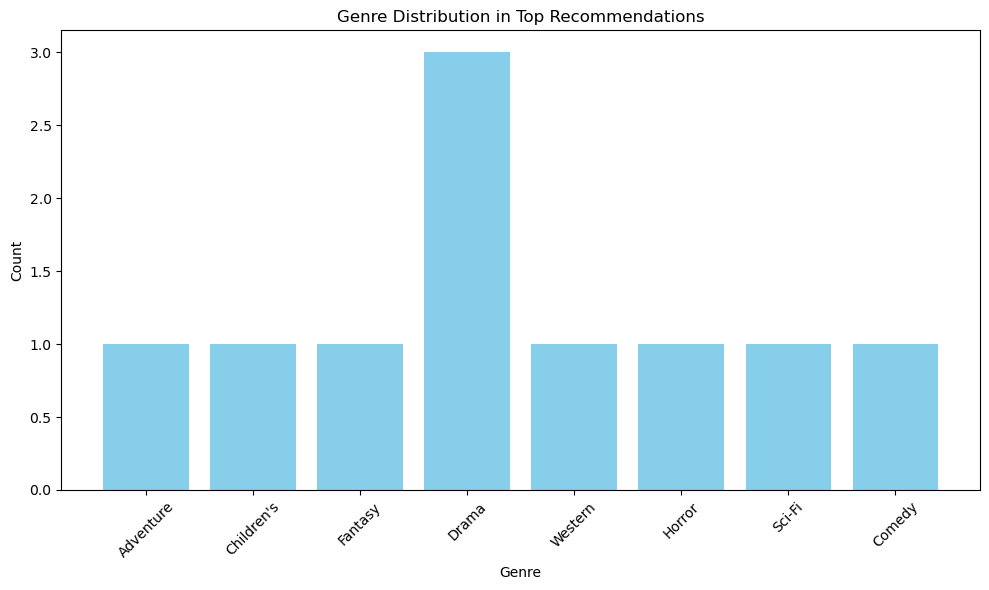

In [44]:
import matplotlib.pyplot as plt
from collections import Counter


movie_id_to_genres = pd.Series(movies.Genres.values, index=movies.MovieID).to_dict()

top_recommended_movies = [1,2695, 1064, 3317, 1593, 1378]  
top_recommended_original_ids = [
    movie_encoder.inverse_transform([encoded_movie_id])[0]
    for encoded_movie_id in top_recommended_movies
]

top_genres = [movie_id_to_genres[movie_id] for movie_id in top_recommended_original_ids]

expanded_genres = []
for genre_list in top_genres:
    expanded_genres.extend(genre_list.split("|"))

genre_counts = Counter(expanded_genres)

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.keys(), genre_counts.values(), color="skyblue")
plt.title("Genre Distribution in Top Recommendations")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
import torch

def recommend_movies(model, movie_name, encoded_movie_name_to_id, encoded_movie_id_to_name, top_k=10):
    
    model.eval()

    if movie_name not in encoded_movie_name_to_id:
        return f"Movie '{movie_name}' not found in the dataset. Please try another movie."

    input_movie_id = encoded_movie_name_to_id[movie_name]

    input_sequence = [0] * (max_len - 1) + [input_movie_id]  # Pad with zeros
    input_tensor = torch.tensor([input_sequence], dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)  # Forward pass
        _, top_k_indices = torch.topk(outputs, k=top_k, dim=1)

    top_k_movie_ids = top_k_indices.cpu().numpy()[0]
    recommended_movies = [
        encoded_movie_id_to_name.get(movie_id, "Unknown Movie") for movie_id in top_k_movie_ids
    ]

    return recommended_movies


if __name__ == "__main__":
    import pickle
    with open("movie_mappings.pkl", "rb") as f:
        mappings = pickle.load(f)
        encoded_movie_id_to_name = mappings["encoded_movie_id_to_name"]
        encoded_movie_name_to_id = mappings["encoded_movie_name_to_id"]

    model = UET4Rec(
        num_items=num_items,
        embedding_dim=embedding_dim,
        nhead=nhead,
        max_len=max_len,
        dropout=0.2,
        ff_dim=ff_dim
    )
    model.load_state_dict(torch.load("uet4rec_model_final.pth", map_location=device))
    model.to(device)

    print("Welcome to the Movie Recommendation System!")
    print("Type a movie name to get recommendations, or type 'exit' to quit.\n")

    while True:
        user_input = input("Enter a movie name: ").strip()
        if user_input.lower() == "exit":
            print("Thank you for using the Movie Recommendation System. Goodbye!")
            break

        recommendations = recommend_movies(
            model, user_input, encoded_movie_name_to_id, encoded_movie_id_to_name, top_k=10
        )

        if isinstance(recommendations, str):  
            print(recommendations)
        else:
            print(f"\nRecommendations for '{user_input}':")
            for idx, rec_movie in enumerate(recommendations, 1):
                print(f"{idx}. {rec_movie}")
            print("\n")


C:\Users\npavi\AppData\Local\Temp\ipykernel_5896\146851217.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("uet4rec_model_final.pth", m

Welcome to the Movie Recommendation System!
Type a movie name to get recommendations, or type 'exit' to quit.



Enter a movie name:  Toy Story (1995)



Recommendations for 'Toy Story (1995)':
1. Toy Story 2 (1999)
2. Groundhog Day (1993)
3. Steel Magnolias (1989)
4. There's Something About Mary (1998)
5. Full Monty, The (1997)
6. Bull Durham (1988)
7. American Beauty (1999)
8. Scary Movie (2000)
9. Young Frankenstein (1974)
10. Wizard of Oz, The (1939)




Enter a movie name:  exit


Thank you for using the Movie Recommendation System. Goodbye!


In [37]:
def get_top_k_predictions(model, input_sequence, k=10):
    model.eval()  
    input_sequence = input_sequence.to(device)
    
    with torch.no_grad():
        output = model(input_sequence)  

    _, top_k_indices = torch.topk(output, k=k, dim=1)  
    return top_k_indices.cpu().numpy()

def evaluate_model_with_batch_size(model, test_dataset, batch_size, k_values):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    metrics = {}

    for k in k_values:
        print(f"\nEvaluating for k = {k} with batch size = {batch_size}")
        model.eval()
        hits, ndcgs = [], []

        for batch_inputs, batch_targets in tqdm(test_loader, desc=f"Evaluating for k={k}", leave=False):
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.cpu().numpy()

            top_k_predictions = get_top_k_predictions(model, batch_inputs, k=k)

            for i, target in enumerate(batch_targets):
                if target in top_k_predictions[i]:
                    hits.append(1)  
                else:
                    hits.append(0)  

                true_relevance = np.zeros((1, num_items))
                true_relevance[0, target] = 1  
                scores = np.zeros((1, num_items))
                scores[0, top_k_predictions[i]] = 1  
                ndcg = ndcg_score(true_relevance, scores, k=k)
                ndcgs.append(ndcg)

        hit_rate = np.mean(hits)
        avg_ndcg = np.mean(ndcgs)

        print(f"HR@{k}: {hit_rate:.4f}")
        print(f"NDCG@{k}: {avg_ndcg:.4f}")
        metrics[k] = {"HR@k": hit_rate, "NDCG@k": avg_ndcg}

    return metrics

test_batch_size = 64  
k_values = [5, 10, 20]

metrics = evaluate_model_with_batch_size(model, test_dataset, test_batch_size, k_values)

print("\nMetrics Summary:")
for k, values in metrics.items():
    print(f"k = {k}: HR@{k} = {values['HR@k']:.4f}, NDCG@{k} = {values['NDCG@k']:.4f}")


Evaluating for k = 5 with batch size = 64


HR@5: 0.4739
NDCG@5: 0.2795

Evaluating for k = 10 with batch size = 64


HR@10: 0.5774
NDCG@10: 0.2624

Evaluating for k = 20 with batch size = 64


HR@20: 0.6850
NDCG@20: 0.2411

Metrics Summary:
k = 5: HR@5 = 0.4739, NDCG@5 = 0.2795
k = 10: HR@10 = 0.5774, NDCG@10 = 0.2624
k = 20: HR@20 = 0.6850, NDCG@20 = 0.2411
